# DAC tests

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/dac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa
import torch
import dacsound
import dac

import utils
from audiotools import AudioSignal

In [22]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")


Available tests:
0: random_sines
1: saw_noise


In [23]:
SAMPLE_RATE = 44100
CURRENT_TEST = 1

Running test: saw_noise


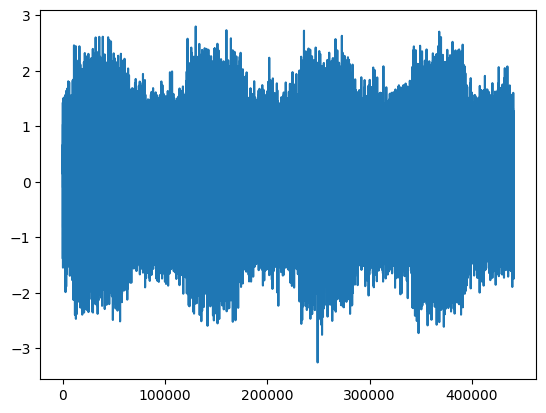

In [24]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
audio = test()

plt.plot(audio)
plt.show()

display(Audio(audio, rate=SAMPLE_RATE))

/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


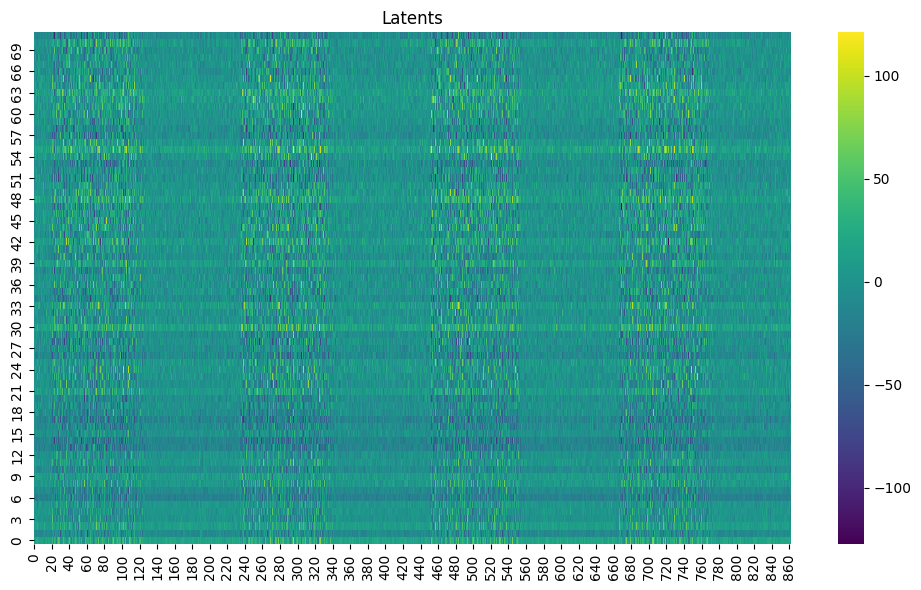

In [25]:
device = torch.device('cpu') # or 'cuda'
GENERATE_LATENTS = False

model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)
model.to(device);
model.eval();

latents = dacsound.DACSound(model, audio, SAMPLE_RATE).latents
latents = latents.cpu().numpy()[0,:,:]
utils.plot_heatmap(latents, title="Latents")


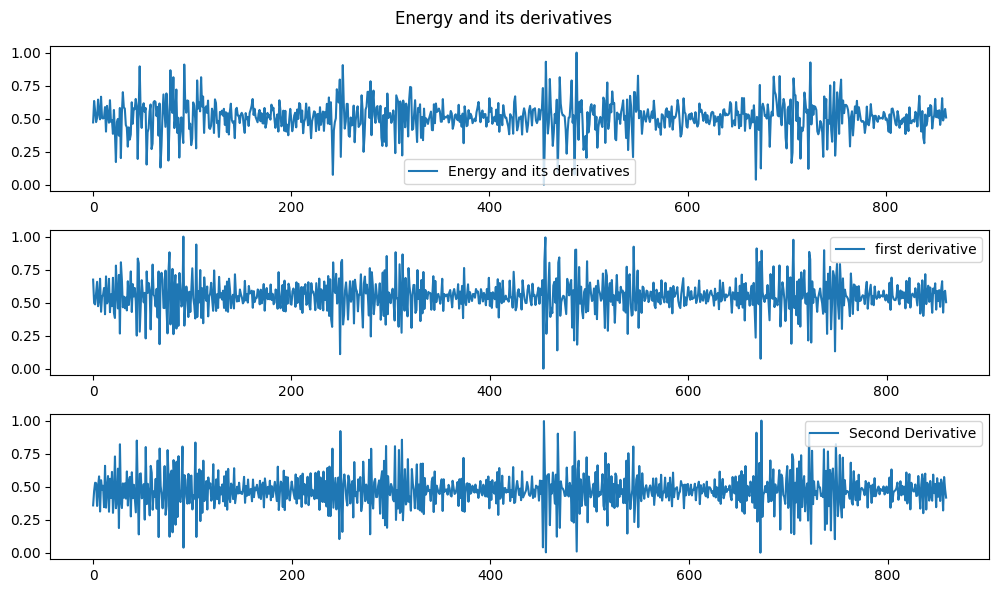

In [26]:
energy = np.sum(latents, axis=0)
d_energy = np.diff(energy)
dd_energy = np.diff(d_energy)

utils.plot_with_derivatives(
    energy,
    d_energy,
    dd_energy,
    title="Energy and its derivatives"
)

distances shape: (72, 861)


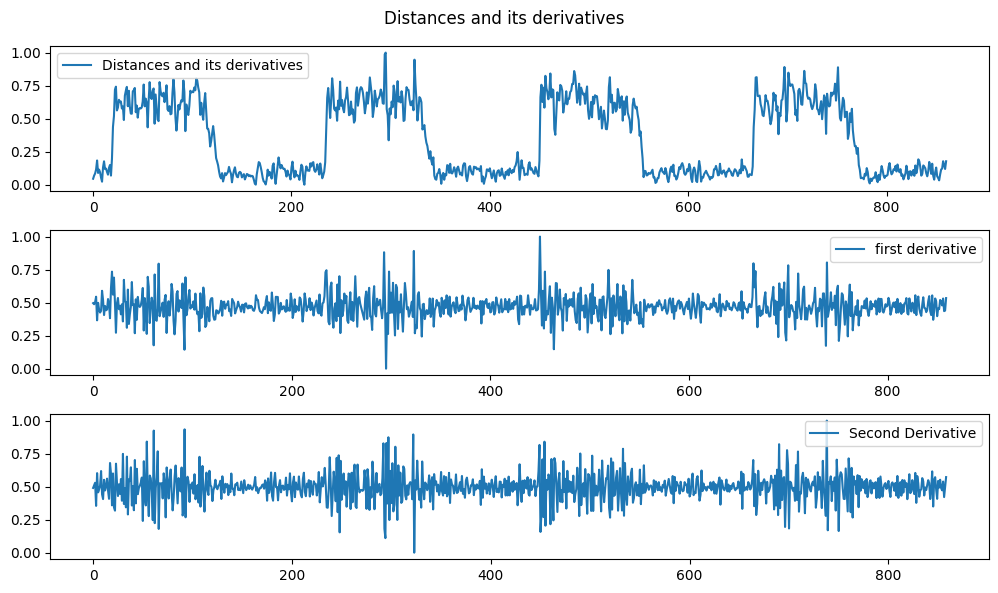

In [27]:
distances = utils.distances(latents)
d_distances = np.diff(distances)
dd_distances = np.diff(d_distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    title="Distances and its derivatives"
)

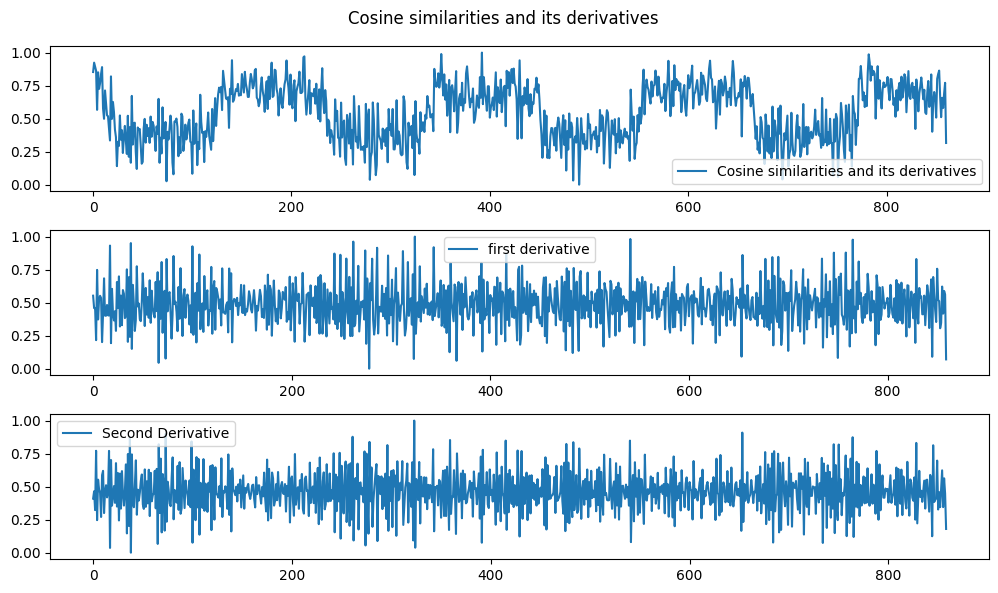

In [28]:
similarities = utils.cosine_similarity(latents)
d_similarities = np.diff(similarities)
dd_similarities = np.diff(d_similarities)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    title="Cosine similarities and its derivatives"
)